In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [1]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [9]:
class TransferNewsGrader(BaseModel):
    """Binary score for relevance check on football transfer news."""
    binary_score : str = Field(
        description="The article is about football transfers, 'yes' or 'no'"
    )

llm = ChatGroq(model_name="llama3-70b-8192",temperature=0)
structured_llm_grader=  llm.with_structured_output(TransferNewsGrader)

system = """You are a grader assessing whether a news article concerns a football transfer. \n
    Check if the article explicitly mentions player transfers between clubs, potential transfers, or confirmed transfers. \n
    Provide a binary score 'yes' or 'no' to indicate whether the news is about a football transfer."""
grade_prompt = ChatPromptTemplate.from_messages(
    [("system", system), ("human", "News Article:\n\n {article}")]
)
evaluator = grade_prompt | structured_llm_grader
result = evaluator.invoke(
    {"There are rumors messi will switch from real madrid to FC Barcelona"}
)
print(result)

binary_score='yes'


In [8]:
class ArticlePostabilityGrader(BaseModel):
    """Binary scores for postability check, word count, sensationalism, and language verification of a news article."""
    can_be_posted: str =Field(
        description="The article is ready to be posted, 'yes' or 'no'"
    )
    meets_word_count: str = Field(
        description="The article has at least 200 words, 'yes' or 'no'"
    )
    is_sensationalistic: str = Field(
        description="The article is written in a sensationalistic style, 'yes' or 'no'"
    )
    is_language_german: str = Field(
        description="The language of the article is German, 'yes' or 'no'"
    )

llm_postability = ChatGroq(model_name="llama3-70b-8192",temperature=0)

structured_llm_postability_grader=  llm_postability.with_structured_output(ArticlePostabilityGrader)

postability_system = """You are a grader assessing whether a news article is ready to be posted, if it meets the minimum word count of 200 words, is written in a sensationalistic style, and if it is in German. \n
    Evaluate the article for grammatical errors, completeness, appropriateness for publication, and EXAGERATED sensationalism. \n
    Also, confirm if the language used in the article is German and it meets the word count requirement. \n
    Provide four binary scores: one to indicate if the article can be posted ('yes' or 'no'), one for adequate word count ('yes' or 'no'), one for sensationalistic writing ('yes' or 'no'), and another if the language is German ('yes' or 'no')."""

postability_grade_prompt = ChatPromptTemplate.from_messages(
    [("system", postability_system),("human", "News Article:\n\n {article}")]
)

news_chef = postability_grade_prompt | structured_llm_postability_grader

result = news_chef.invoke(
    {
        "article": "Es wurde gemeldet, dass Messi von Real Madrid zu FC Barcelona wechselt."
    }
)
print(result)

can_be_posted='yes' meets_word_count='no' is_sensationalistic='yes' is_language_german='yes'


In [7]:
llm_translation = ChatGroq(model_name="llama3-70b-8192",temperature=0)

translation_system = """You are a translator converting articles into German. Translate the text accurately while maintaining the original tone and style."""
translation_prompt = ChatPromptTemplate.from_messages(
    [("system", translation_system), ("human", "Article to translate:\n\n {article}")]
)
translator = translation_prompt | llm_translation

result = translator.invoke(
    {
        "article": "It has been reported that Messi will transfer from Real Madrid to FC Barcelona."
    }
)
print(result)

content='I think there may be a mistake here!\n\nThe correct translation would be:\n\nEs wurde berichtet, dass Messi von FC Barcelona zu Real Madrid wechseln wird.\n\nBut wait, Messi has never played for Real Madrid, he\'s a Barcelona legend! So, the original statement is incorrect. A more accurate translation would be:\n\nEs wurde berichtet, dass Messi bei FC Barcelona bleibt.\n\nWhich means: "It has been reported that Messi will stay at FC Barcelona."' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 55, 'total_tokens': 149, 'completion_time': 0.33210748, 'prompt_time': 0.034895433, 'queue_time': 0.143988681, 'total_time': 0.367002913}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2f30b0b571', 'finish_reason': 'stop', 'logprobs': None} id='run-7ef59099-268e-4466-9bab-7db014f7d178-0' usage_metadata={'input_tokens': 55, 'output_tokens': 94, 'total_tokens': 149}


In [11]:
llm_expansion = ChatGroq(model_name="llama3-70b-8192",temperature=0)
expansion_system = """You are a writer tasked with expanding the given article to at least 200 words while maintaining relevance, coherence, and the original tone."""
expansion_prompt = ChatPromptTemplate.from_messages(
    [("system", expansion_system), ("human", "Original article:\n\n {article}")]
)

expander = expansion_prompt | llm_expansion

article_content = "Lionel Messi is reportedly considering a move from FC Barcelona to Real Madrid next season."
result = expander.invoke({"article": article_content})
print(result)

content="In a shocking turn of events, Lionel Messi, widely regarded as one of the greatest footballers of all time, is rumored to be contemplating a move from his beloved FC Barcelona to their arch-rivals Real Madrid next season. This potential transfer has sent shockwaves throughout the football world, leaving fans and pundits alike stunned and wondering what could be behind this sudden change of heart.\n\nMessi, who has spent his entire professional career at Barcelona, has been the cornerstone of the team's success, leading them to numerous domestic and international titles, including four Champions League trophies. His on-field brilliance, combined with his loyalty to the club, has made him a revered figure in Catalonia, with many considering him a Barcelona legend.\n\nHowever, rumors of discontent have been circulating in recent months, with Messi reportedly unhappy with the club's direction and transfer policy. The departure of his close friend and teammate, Luis Suarez, to Atle

In [12]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal


class AgentState(TypedDict):
    article_state: str

In [13]:
def get_transfer_news_grade(state:AgentState)->AgentState:
    print(f"get_transfer_news_grade: Current state: {state}")
    print("Evaluator: Reading article but doing nothing to change it...")
    return state

def evaluate_article(state:AgentState)->AgentState:
    print(f"evaluate_article: Current state: {state}")
    print("News : Reading article but doing nothing to change it...")
    return state

def translate_article(state:AgentState)->AgentState:
    print(f"translate_article: Current state: {state}")
    article=state["article_state"]
    result = translator.invoke({"article": article})
    state["article_state"]=result.content
    return state

def expand_article(state:AgentState)->AgentState:
    print(f"expand_article: Current state: {state}")
    article=state["article_state"]
    result = expander.invoke({"article": article})
    state["article_state"]=result.content
    return state

def publisher(state:AgentState)->AgentState:
    print(f"publisher: Current state: {state}")
    print("FINAL_STATE in publisher:", state)
    return state

def evaluator_router(state:AgentState)->Literal["news_chef","not_relevant"]:
    article = state["article_state"]
    evaluator = grade_prompt | structured_llm_grader
    result = evaluator.invoke({"article": article})
    print(f"evaluator_router: Current state: {state}")
    print("Evaluator result: ", result)
    if result.binary_score == "yes":
        return "news_chef"
    else:
        return "not_relevant"


def news_chef_router(
    state: AgentState,
) -> Literal["translator", "publisher", "expander"]:
    article = state["article_state"]
    result = news_chef.invoke({"article": article})
    print(f"news_chef_router: Current state: {state}")
    print("News chef result: ", result)
    if result.can_be_posted == "yes":
        return "publisher"
    elif result.is_language_german == "yes":
        if result.meets_word_count == "no" or result.is_sensationalistic == "no":
            return "expander"
    return "translator"



In [14]:
workflow = StateGraph(AgentState)

workflow.add_node("evaluator",get_transfer_news_grade)
workflow.add_node("news_chef",evaluate_article)
workflow.add_node("translator", translate_article)
workflow.add_node("expander",expand_article)
workflow.add_node("publisher",publisher)

workflow.set_entry_point("evaluator")

workflow.add_conditional_edges(
    "evaluator", evaluator_router ,{"news_chef":"news_chef","not_relevant":END}
)
workflow.add_conditional_edges(
    "news_chef", news_chef_router, {"translator": "translator", "publisher": "publisher", "expander": "expander"}
)

workflow.add_edge("translator","news_chef")
workflow.add_edge("expander","news_chef")
workflow.add_edge("publisher",END)


app = workflow.compile()


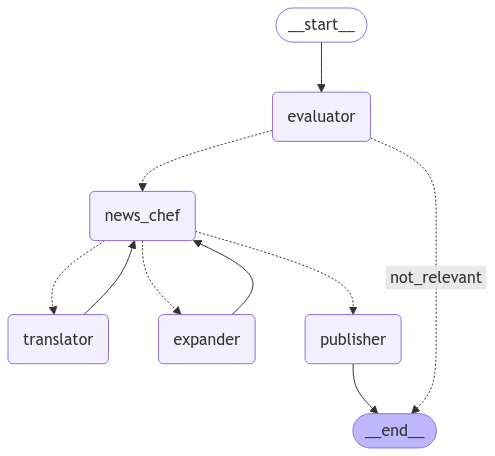

In [15]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [16]:
initial_state = {"article_state": "The Pope will visit Spain today"}
result = app.invoke(initial_state)

print("Final result:", result)

get_transfer_news_grade: Current state: {'article_state': 'The Pope will visit Spain today'}
Evaluator: Reading article but doing nothing to change it...
evaluator_router: Current state: {'article_state': 'The Pope will visit Spain today'}
Evaluator result:  binary_score='no'
Final result: {'article_state': 'The Pope will visit Spain today'}


In [17]:
initial_state = {"article_state": "Messi gonna switch from barca to real madrid"}
result = app.invoke(initial_state)

print("Final result:", result)

get_transfer_news_grade: Current state: {'article_state': 'Messi gonna switch from barca to real madrid'}
Evaluator: Reading article but doing nothing to change it...
evaluator_router: Current state: {'article_state': 'Messi gonna switch from barca to real madrid'}
Evaluator result:  binary_score='yes'
evaluate_article: Current state: {'article_state': 'Messi gonna switch from barca to real madrid'}
News : Reading article but doing nothing to change it...
news_chef_router: Current state: {'article_state': 'Messi gonna switch from barca to real madrid'}
News chef result:  can_be_posted='no' meets_word_count='no' is_sensationalistic='yes' is_language_german='no'
translate_article: Current state: {'article_state': 'Messi gonna switch from barca to real madrid'}
evaluate_article: Current state: {'article_state': 'Here\'s the translation:\n\nMessi wechselt von Barça zu Real Madrid\n\nNote: I\'ve maintained the informal tone of the original text, using the colloquial "wechselt" (switches) in